In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from typing import Dict
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary, pos
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [4]:
sym = 'NQ'
start_date = '20180601'
end_date='20181231'
periods=[10,20,40,80]
roc_periods=[5,40]
b_periods=[10]
s='20180501'
params = {
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=b_periods),
}

inds = {
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=b_periods),
}

In [5]:
def binarize(series):
    df = pd.DataFrame()
    df['long'] = (series > 0) * 1
    df['short'] = (series < 0) * -1
    df['out'] = (series == 0) * 0
    df['signal'] = df.sum(axis=1)
    return df['signal']

In [6]:
def combine(inds: Dict[str, pd.DataFrame]):
    df_in = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df_out = pd.DataFrame({name: binarize(df_in[name]) for name in df_in.columns})
    df_out['forecast'] = df_out.mean(axis=1).round()
    df_out[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    return df_out

In [7]:
data=combine(inds)

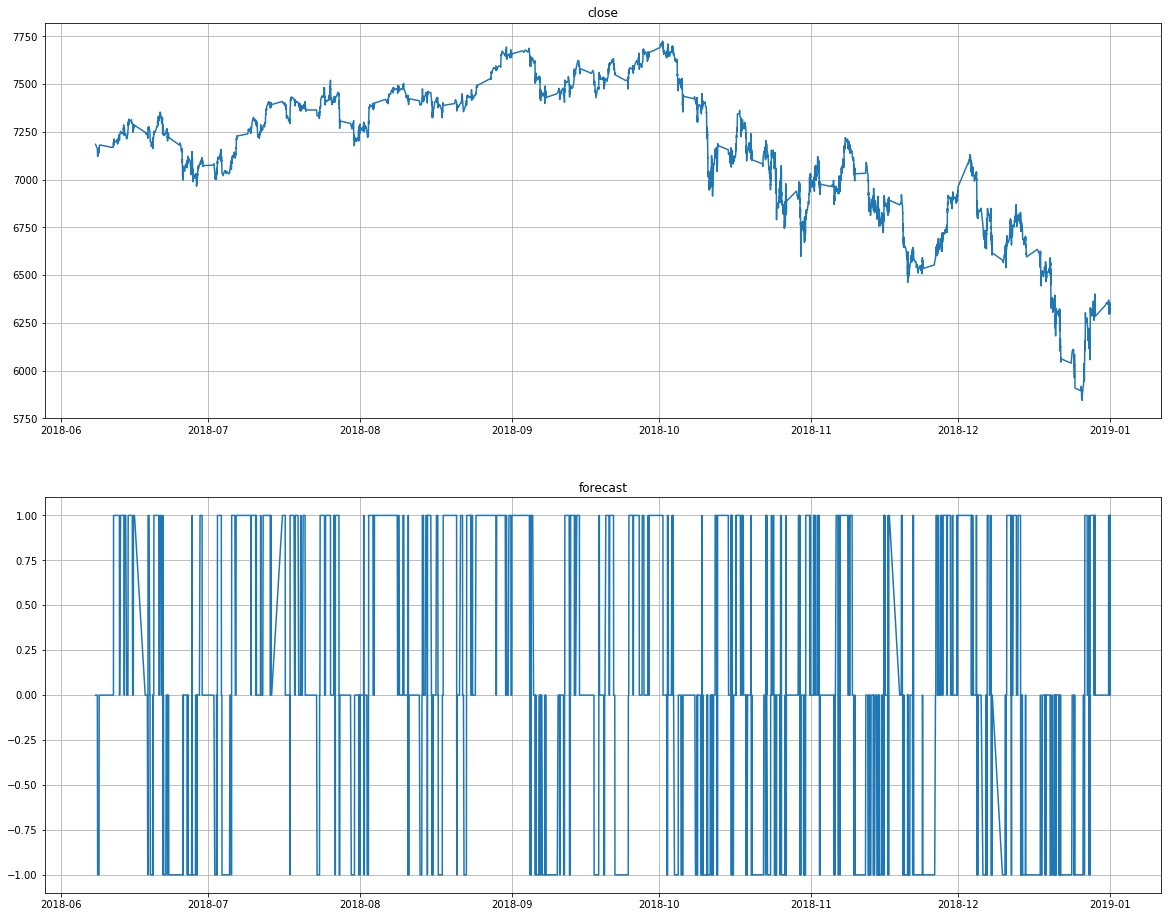

In [8]:
plot(data[['close', 'forecast']])

In [9]:
out = summary(data, slip=1.5, threshold=0)
out.stats

,0
Annual return,-0.147272
Cumulative returns,-0.0881695
Annual volatility,0.168587
Sharpe ratio,-0.860902
Calmar ratio,-1.19101
Stability,0.191632
Max drawdown,-0.123652
Omega ratio,0.863439
Sortino ratio,-1.17031
Skew,-0.0189785


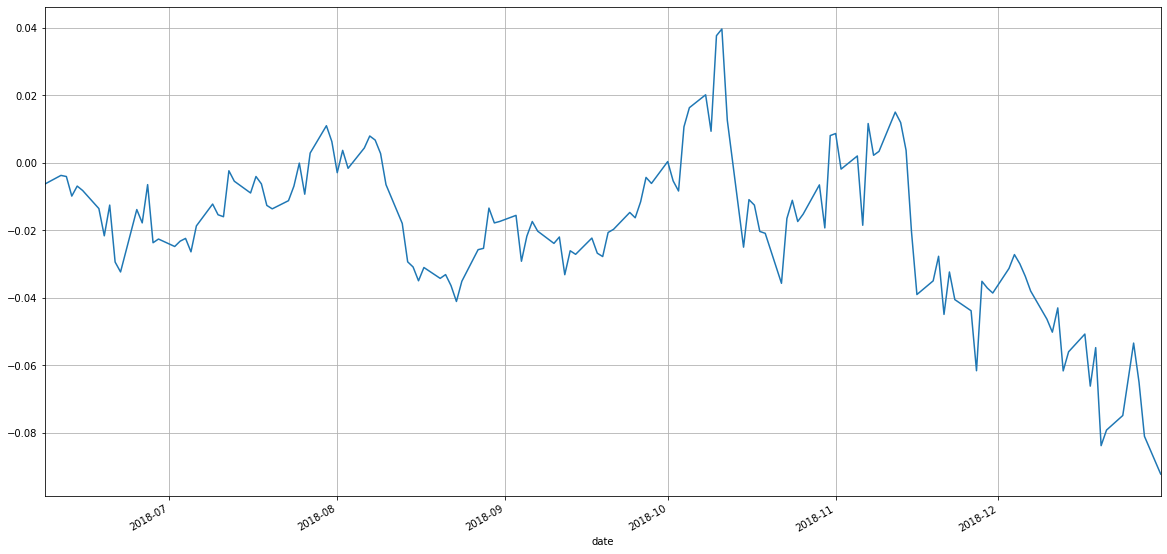

In [10]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [11]:
out.returns.tail(20)

,0
date,
2018-12-03,0.007326
2018-12-04,0.004108
2018-12-05,-0.002737
2018-12-06,-0.003668
2018-12-07,-0.004399
2018-12-10,-0.008294
2018-12-11,-0.003848
2018-12-12,0.007221
2018-12-13,-0.018504


In [12]:
b = v_backtester(data.close, data.forecast, 0)

In [13]:
#b= v_backtester(inds['ema'].close, inds['ema'].forecast, 0)

In [14]:
b

,price,indicator,signal,position
date,,,,
2018-06-08 00:01:00,7184.75,0.0,0,0
2018-06-08 08:47:00,7161.75,0.0,0,0
2018-06-08 10:12:00,7121.25,-1.0,-1,0
2018-06-08 12:17:00,7128.00,-1.0,-1,-1
2018-06-08 14:29:00,7145.75,-1.0,-1,-1
...,...,...,...,...
2018-12-31 21:56:00,6299.25,0.0,0,1
2018-12-31 21:59:00,6345.75,0.0,0,0
2018-12-31 22:01:00,6350.75,1.0,1,0


In [15]:
r = perf_var(b, False, slippage=1.5)

In [16]:
d = r.df
d.head(20)

,price,indicator,signal,position,transaction,slippage,curr_price,base_price,pnl,lreturn
date,,,,,,,,,,
2018-06-08 00:01:00,7184.75,0.0,0,0,0,0.000,0.00,0.00,0.000,0.000000
2018-06-08 08:47:00,7161.75,0.0,0,0,0,0.000,0.00,0.00,0.000,0.000000
2018-06-08 10:12:00,7121.25,-1.0,-1,0,0,0.000,0.00,0.00,0.000,0.000000
2018-06-08 12:17:00,7128.00,-1.0,-1,-1,-1,0.375,0.00,0.00,-0.375,-0.000053
2018-06-08 14:29:00,7145.75,-1.0,-1,-1,0,0.000,-7145.75,-7128.00,-17.750,-0.002493
2018-06-08 15:31:00,7151.25,-1.0,-1,-1,0,0.000,-7151.25,-7145.75,-5.500,-0.000770
2018-06-08 15:44:00,7150.75,-1.0,-1,-1,0,0.000,-7150.75,-7151.25,0.500,0.000070
2018-06-08 15:58:00,7160.50,-1.0,-1,-1,0,0.000,-7160.50,-7150.75,-9.750,-0.001364
2018-06-08 16:19:00,7160.50,-1.0,-1,-1,0,0.000,-7160.50,-7160.50,0.000,0.000000


In [27]:
data = pd.DataFrame({'pnl': d.pnl, 'price': d.price, 'lreturn': d.lreturn})
daily = data.resample('B').agg({'pnl': 'sum', 'price': 'first', 'lreturn': 'sum'})

In [28]:
daily

,pnl,price,lreturn
date,,,
2018-06-08,-31.250,7184.75,-0.004399
2018-06-11,19.625,7168.75,0.002730
2018-06-12,24.625,7197.00,0.003415
2018-06-13,5.375,7253.00,0.000741
2018-06-14,20.000,7239.00,0.002721
...,...,...,...
2018-12-25,0.000,NaN,0.000000
2018-12-26,82.250,5894.75,0.012661
2018-12-27,-58.000,6266.00,-0.009779


In [ ]:
daily['returns'] = np.exp(daily['lreturn'])
daily['balance'] = (daily['returns'] + 1).cumprod()


In [17]:
df['test'] = df['pnl'] / 

SyntaxError: invalid syntax (<ipython-input-17-449eb540b88b>, line 1)

In [ ]:
-.375/7128+1

In [ ]:
d.loc['20181213':].head(50)

In [ ]:
r.positions

In [ ]:
d['pnl'].sum()

In [ ]:
d.head(50)

In [ ]:
data

In [ ]:
0.00575232888909134

In [ ]:
x=np.log(1520/1500)
x

In [ ]:
np.exp(x)*1500

In [ ]:
np.random.seed(0)
df = pd.DataFrame(100 + np.random.randn(100).cumsum(), columns=['price'])

In [ ]:
df

In [ ]:
df['return'] = np.log(df['price'].pct_change()+1)
df

In [ ]:
s=df['return'].sum()
s

In [ ]:
np.exp(s)*df['price'][0]

In [ ]:
df['price'].iloc[-1]